# Slice Data Sets into images for traing!

This is for slicing the ~ 20mb images into smaller images that represent flooded or normal areas. This will allow us to make a 'patch work quilt' during inference!

In [1]:

%matplotlib notebook
import matplotlib

import numpy as np
import cv2
import os

from ipywidgets import widgets, interact, interactive, fixed, interact_manual
import matplotlib.pyplot as plt
import math
import time
from IPython.display import display
%gui asyncio
import asyncio

1. Set source path of the large source image.
2. Set paths representing the save dirs for the cropped images.
3. Set the shape of the crops
4. We will then get the maximum number of whole, non-overlapping crops from the image in total_in_x and total_in_y. You may see better performace with overlaping crops and distortions such as contrast changes/rotation but let's keep its simple for now.

**Note:** I would normally use arg parse for this..because you can set these file paths are cli arguments.

In [2]:
image_path = '.../DP_SURAT_AERIALPHOTO_2011_2M/20110104_1415-1512_Surat_2mB1.jpg'
flood_path = '.../training_images/flood_images'
non_flood_path = '.../training_images/non_flood'
org_image = cv2.imread(image_path)
# org_image = cv2.imread(image_path, cv2.IMREAD_REDUCED_COLOR_8)
x, y, z = org_image.shape
x_shape = 256
y_shape = 256 
total_in_x = math.floor(x/x_shape)
total_in_y = math.floor(y/y_shape)

In [3]:
def crop_to_coords(coords):

    x1,x2,y1,y2 = coords
    
    return org_image[y1:y2,x1:x2,:]   

* It turns out it's nessessary to run both the wigits and the matplotlib code in asyncio. If found this out after quite a few hours debugging. Basically, we run in async due to Ipython wigits dataflow requiring this for a blocking call that awaits change in the slider.


* I would normally do this with **OpenCV** and key bindings representing the classes to save into. But this is a portfolio piece so I wanted it easy to view and run in Jupyter.

In [4]:
def wait_for_change(widget, value):
    future = asyncio.Future()
    def getvalue(change):
        # make the new value available
        future.set_result(change.new)
        widget.unobserve(getvalue, value)
    widget.observe(getvalue, value)
    print('before return')
    return future

Just click **either** far left or right of the slider to put into the classes. If you make a mistake just delete the file and continue. 

Example of the interface:
<p align="center">
<img src="slicing_example.png" width="50%""/>
</p>

SelectionSlider(continuous_update=False, description='flood selection', index=1, options=('non-flood', 'null',…

<Task pending coro=<f() running at <ipython-input-6-1f1719f86316>:24>>

<IPython.core.display.Javascript object>


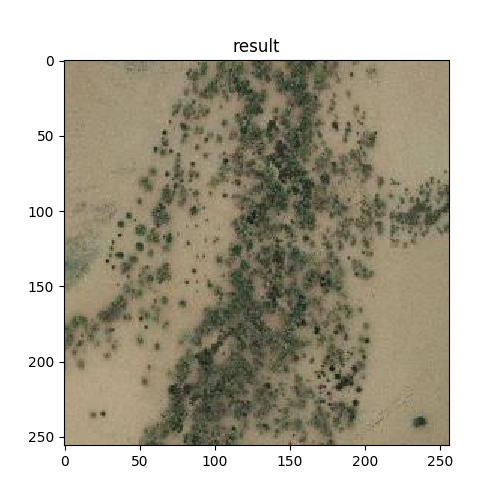

In [6]:

flood_slider = widgets.SelectionSlider(
    options=['non-flood', 'null', 'flood'],
    value='null',
    description='flood selection',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True
)
display(flood_slider)


async def plot_fig(to_plot):
#             image_plots = plt.figure(1)
            image_plots = plt.figure(1, figsize=(5, 5))
            
            fig = image_plots.add_subplot(1,1,1)
            fig.imshow(cv2.cvtColor(to_plot, cv2.COLOR_BGR2RGBA))
            fig.set_title('result')
            plt.show()
            return 
    
async def f(total_in_x, total_in_y, org_image, flood_path, non_flood_path):
    x1 = 0
    x2 = 0
    y1 = 0
    y2 = 0
    for i in range(total_in_y):
        
        for j in range(total_in_x):
            path = ''
            x1 = x_shape*j
            x2 = x_shape*(j+1)
            y1 = y_shape*i
            y2 = y_shape*(i+1)
            coords = (x1,x2,y1,y2)

            result = crop_to_coords((x1,x2,y1,y2))

            await plot_fig(result)

            flood_decision = await wait_for_change(flood_slider, 'value')
            
            if flood_decision == 'flood':
                path = image_path.split('/')[-1].split('.')[0] + '_' + 'flood_'+'x1'+str(x1)+'x2'+str(x2)+'y1'+str(y1)+'y2'+str(y2)+'.png'
                cv2.imwrite(os.path.join(flood_path,path), result) 
                
            elif flood_decision == 'non-flood':

                path = image_path.split('/')[-1].split('.')[0] + '_' + 'not_flood_'+'x1'+str(x1)+'x2'+str(x2)+'y1'+str(y1)+'y2'+str(y2)+'.png'
                cv2.imwrite(os.path.join(non_flood_path,path), result) 
                        
            print('async function continued with value %s'%flood_decision)
        
            flood_slider.value = 'null'
    print('All Done!')
            
asyncio.ensure_future(f(total_in_x, total_in_y, org_image, flood_path, non_flood_path))


# Final notes:

* Make sure you select some of these images to go into the validation images classes so we can test performace during training to decide if we want to stop early or not!

---
## Make Train/Validation Datasets using 15% of the images made above:

In [ ]:
import shutil

In [ ]:
validation_dir = '.../Flood_detector/validation_images'

In [ ]:
train_dir = '.../Flood_detector/training_images'

In [ ]:
for class_folder in os.listdir(train_dir):
    print(class_folder)
    if class_folder != '.DS_Store' and os.path.isdir(os.path.join(train_dir, class_folder)):
        
        np.random.seed(1)
        images_in_class = [str(j) for j in os.listdir(path=os.path.join(train_dir, class_folder)) if not j.startswith('.')]
        np.random.shuffle(images_in_class)
        

        for i in images_in_class[:int(len(images_in_class)*0.15)]:
            
            shutil.move(os.path.join(train_dir, class_folder,i), os.path.join(validation_dir, class_folder, i))        